In [3]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/27fb855b027ead16d2616dcb59c67409a2176b7f/official/nlp/tools/tokenization.py

In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [5]:
gpus = tf.config.list_physical_devices('GPU')
gpus

2022-02-26 19:43:35.157785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 19:43:35.285819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 19:43:35.286962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

### Data cleaning

In [7]:
def relabel(df, label, text):
    df.loc[df.text == text, 'target'] = label

relabel(df_train, 1, '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4')
relabel(df_train, 0, '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect')
relabel(df_train, 0, '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption')
relabel(df_train, 1, 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring')
relabel(df_train, 1, 'Caution: breathing may be hazardous to your health.')
relabel(df_train, 0, 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam')
relabel(df_train, 0, 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife')
relabel(df_train, 0, 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!')
relabel(df_train, 0, 'I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????')
relabel(df_train, 0, 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!')
relabel(df_train, 0, "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...")
relabel(df_train, 1, 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG')
relabel(df_train, 0, "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'")
relabel(df_train, 0, 'To fight bioterrorism sir.')
relabel(df_train, 1, 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE')
relabel(df_train, 0, 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit')
relabel(df_train, 0, 'that horrible sinking feeling when you\x89Ûªve been at home on your phone for a while and you realise its been on 3G this whole time')
relabel(df_train, 0, 'wowo--=== 12000 Nigerian refugees repatriated from Cameroon')


In [8]:
df_train.drop_duplicates(subset=['keyword', 'location', 'text', 'target'], inplace=True)

In [9]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df_train['text'] = df_train['text'].apply(remove_URL)
df_test['text'] = df_test['text'].apply(remove_URL)

In [10]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df_train['text'] = df_train['text'].apply(remove_html)
df_test['text'] = df_test['text'].apply(remove_html)

In [11]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
X_train, X_dev, y_train, y_dev = train_test_split(df_train['text'], df_train['target'],
                                                  test_size=0.1, stratify=df_train['target'], shuffle=True)

In [13]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))

In [14]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

2022-02-26 19:43:48.240712: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-26 19:43:48.242687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 19:43:48.243852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 19:43:48.244908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [26]:
class DisasterDetector:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=1e-4, epochs=15, batch_size=32):
        
        self.bert_layer = bert_layer
        self.max_seq_length = max_seq_length
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        # Hyperparameters
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.models = []
        self.scores = []
        
    def encode(self, texts):
        all_tokens = []
        all_masks = []
        all_segments = []
        
        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length-2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            
            pad_len = self.max_seq_length - len(input_sequence)
            pad_masks = [1]*len(input_sequence) + [0]*pad_len
            
            segment_ids = [0]*self.max_seq_length
            
            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0]*pad_len
            
            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)
            
        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])
        
        """text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
        encoder_inputs = preprocessing_layer(text_input)
        outputs = self.bert_layer(encoder_inputs)"""

        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)
        #model = Model(inputs=text_input, outputs=out)
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        
        

        return model
    
    def train(self, X, y):
        X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.1, stratify=y, shuffle=True)
        X_train_encoded = self.encode(X_train.str.lower())
        X_dev_encoded = self.encode(X_dev.str.lower())
        
        metrics = ClassificationReport(train_data=(X_train_encoded, y_train), validation_data=(X_dev_encoded, y_dev))
        model = self.build_model()
        
        """steps_per_epoch = len(X)
        num_train_steps = steps_per_epoch * self.epochs
        num_warmup_steps = int(0.1*num_train_steps)

        optimizer = optimization.create_optimizer(init_lr=self.lr,
                                                  num_train_steps=num_train_steps,
                                                  num_warmup_steps=num_warmup_steps,
                                                  optimizer_type='adamw')"""
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        model.fit(X_train_encoded, y_train, validation_data=(X_dev_encoded, y_dev), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)
        
        self.models.append(model)
        self.scores.append({
            'train': {
                'precision': metrics.train_precision_scores,
                'recall': metrics.train_recall_scores,
                'f1': metrics.train_f1_scores                    
            },
            'validation': {
                'precision': metrics.val_precision_scores,
                'recall': metrics.val_recall_scores,
                'f1': metrics.val_f1_scores                    
            }
        })
        
    def plot_learning_curve(self):
        K=1
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
    
    def predict(self, X):

        X_test_encoded = self.encode(X.str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred   
        
        
        
            
        

In [27]:
clf = DisasterDetector(bert_layer, max_seq_length=128, batch_size=32) #lr=3e-5, epochs=5, 

clf.train(df_train['text'].str.lower(), df_train['target'])

Epoch 1/15
213/213 [==============================] - 107s 468ms/step - loss: 0.5131 - accuracy: 0.7594 - val_loss: 0.4708 - val_accuracy: 0.7870

Epoch: 1 - Training Precision: 0.801436 - Training Recall: 0.796431 - Training F1: 0.798445
Epoch: 1 - Validation Precision: 0.782961 - Validation Recall: 0.780268 - Validation F1: 0.781438
Epoch 2/15
213/213 [==============================] - 98s 461ms/step - loss: 0.4266 - accuracy: 0.8170 - val_loss: 0.4417 - val_accuracy: 0.8082

Epoch: 2 - Training Precision: 0.823474 - Training Recall: 0.819175 - Training F1: 0.820987
Epoch: 2 - Validation Precision: 0.805425 - Validation Recall: 0.80071 - Validation F1: 0.802631
Epoch 3/15
213/213 [==============================] - 98s 461ms/step - loss: 0.3996 - accuracy: 0.8333 - val_loss: 0.4225 - val_accuracy: 0.8175

Epoch: 3 - Training Precision: 0.849894 - Training Recall: 0.828135 - Training F1: 0.83433
Epoch: 3 - Validation Precision: 0.824039 - Validation Recall: 0.802501 - Validation F1: 0.

KeyError: 'val_accuracy'

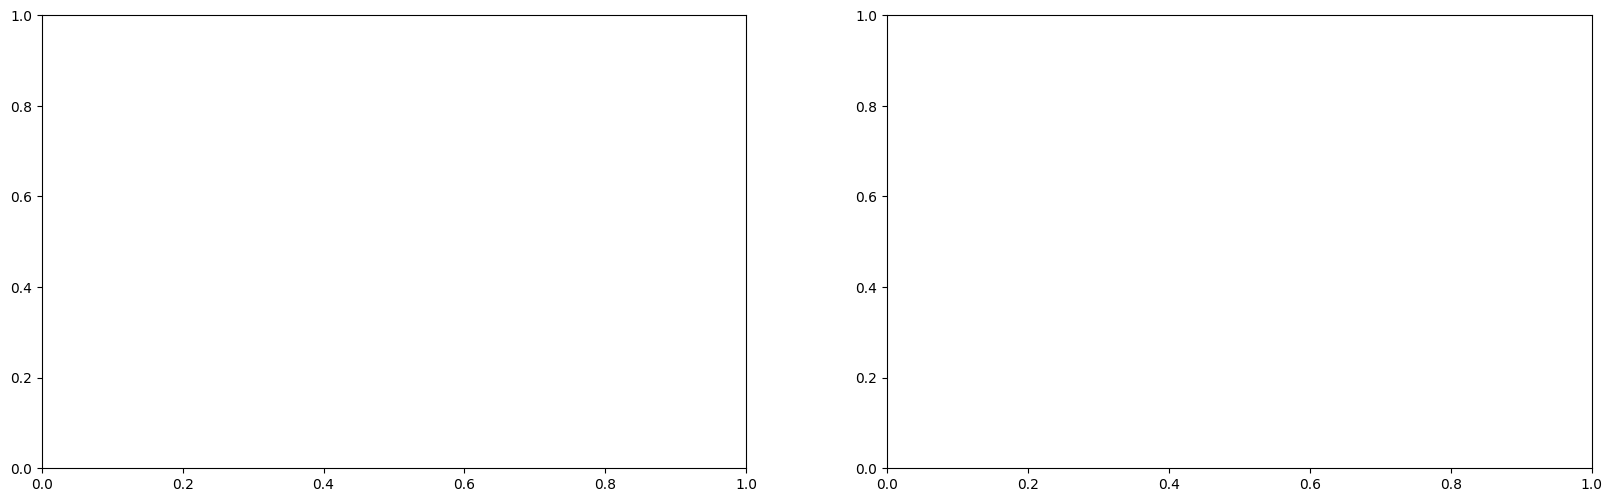

In [33]:
clf.plot_learning_curve()

In [28]:
y_pred = clf.predict(df_test['text'].str.lower())

model_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission.csv', index=False)